#  1 Preparation 准备

## 1.1 数据展示

每个npy文件前3个元素是原始图像的RGB三个通道，第4个元素是背景遮罩，第5-12个元素是车辆模块的遮罩，第13个元素是车辆所有模块的混合遮罩

图片来自imagenet, 所以图片的mean = [0.485,0.456,0.406], std = [0.229,0.224,0.225]

In [ ]:
import torch
torch.cuda.is_available()
torch.cuda.device_count()

In [1]:
import numpy as np
mean = np.array([0.485,0.456,0.406])
std  = np.array([0.229,0.224,0.225])
car_parts = ['background','front_door','back_door','fender','frame','bumper','hood','back_bumper','trunk']

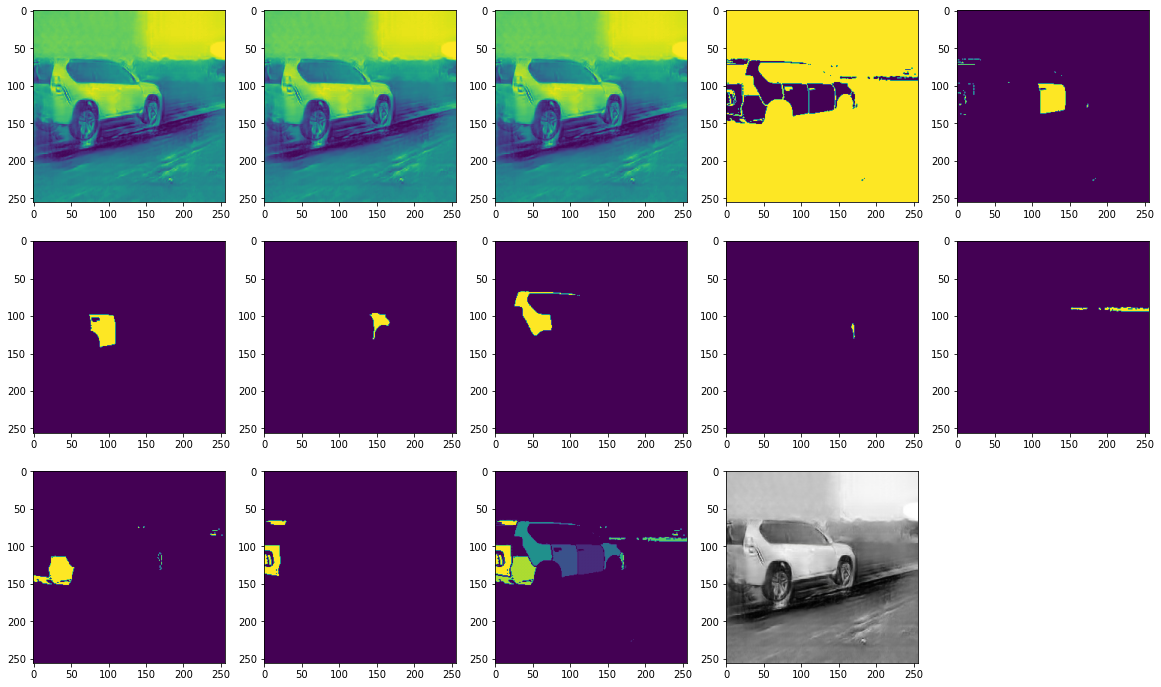

In [3]:
import numpy as np
import matplotlib.pyplot as plt
pic = np.load("/zhome/f0/a/165104/car/small_data/251.npy")
plt.figure(figsize=(20,12))
for i in range(pic.shape[0]):
    plt.subplot(3,5,i+1)
    plt.imshow(pic[i])
plt.subplot(3,5,14)
raw_img = np.empty((256,256,3))
raw_img[:,:,0] = pic[0,:,:] + 0.485 / 0.229
raw_img[:,:,1] = pic[1,:,:] + 0.456 / 0.224
raw_img[:,:,2] = pic[2,:,:] + 0.406 / 0.225
plt.imshow(raw_img)

# import cv2
# img_float32 = np.float32(raw_img) # cv2 only support 32bit float
# img_cv = cv2.cvtColor(img_float32, cv2.COLOR_RGB2BGR)
# cv2.imshow('car', img_cv)

## 1.2 Image resize and Normalization

In [2]:
from PIL import Image
def image_size_alignment(path,size=(256,256)):
    img = Image.open(path)
    temp = max(img.size)
    mask = Image.new('RGB', (temp,temp),(0,0,0))
    mask.paste(img,(0,0))
    mask.resize(size)
    return mask

## 1.3 Data generator 数据生成器
- 'background': (,,),
- 'front_door': (20, 100, 20),
- 'back_door': (250, 250, 10),
- 'fender': (20, 20, 250),
- 'frame': (10, 250, 250),
- 'bumper': (250, 10, 250),
- 'hood': (250, 150, 10),
- 'back_bumper': (150, 10, 150),
- 'trunk': (10, 250, 10)

In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms

trans = transforms.ToTensor()

class CarDataset(Dataset):
    def __init__(self,path):
        self.path = path
        self.names = os.listdir(path)
        for i, name in enumerate(self.names):
            if os.path.splitext(name)[1] != '.npy':
                # three way to delete, pop(index), del list[index], remove(value). and clear() wipe out all
                self.names.pop(i)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, index):
        name = self.names[index]
        path = os.path.join(self.path, name)
        img = np.load(path).astype(np.double)
        car_img = img[:3] # normalized 3 channel
        mask_imgs = img[3:12]
        return torch.from_numpy(car_img).to(dtype=torch.float32), \
               torch.from_numpy(mask_imgs).to(dtype=torch.float32) # 32bit is faster than 64bit

### 1.3.1 Unit test 单元测试

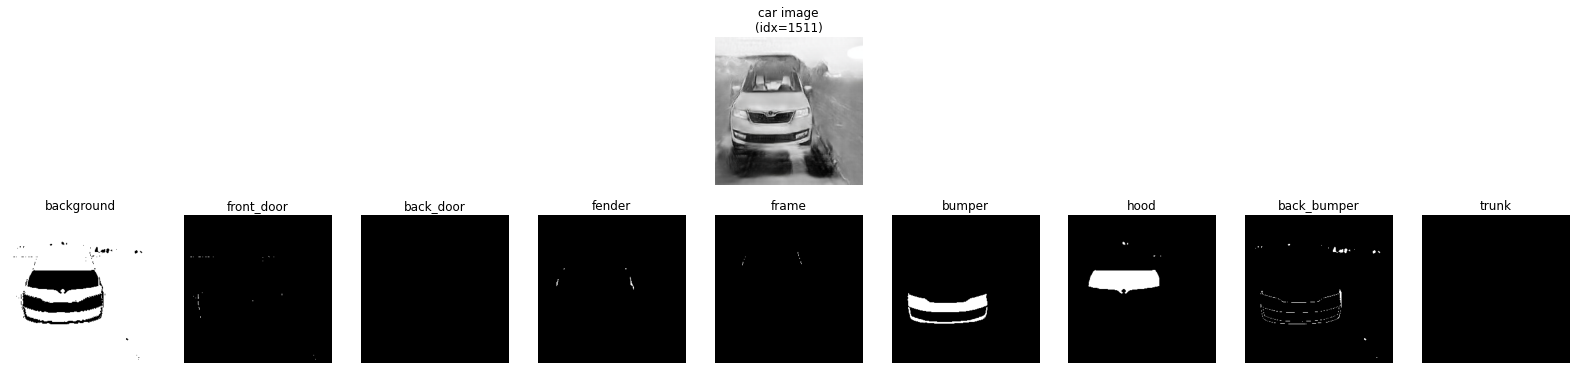

In [6]:
import random
# unit test
# if __name__ == '__main__':
data = CarDataset('/zhome/f0/a/165104/car/small_data')
idx = random.randint(0,len(data))
car_img, car_masks = data[idx]

# transpose channel dim and de-nomalization
car_img = ((car_img.numpy().transpose(1,2,0) + mean / std) * 255).astype(np.int32)
car_masks = (car_masks.numpy().transpose(1,2,0) * 255).astype(np.int32)
plt.figure(figsize=(28,6))
plt.subplot(2,9,5)
plt.axis('off')
plt.imshow(car_img)
plt.title(f'car image\n(idx={idx})')
for i in range(9):
    plt.subplot(2,9,i+10)
    plt.axis('off')
    plt.imshow(car_masks[:,:,i], cmap=plt.cm.gray)
    plt.title(f'{car_parts[i]}')

In [35]:
# test make grid
from torch.utils.data import random_split, DataLoader
from torchvision.utils import save_image
data = CarDataset('/Users/baixiang/car/data')
data_loader = DataLoader(data, batch_size=2)
save_path = os.path.join('/Users/baixiang/car/fcn/save','fcn32s')
image, target = iter(data_loader).next()
print(target.size(), image.size())

def image_dim_expansion(tensor, num_classes=9):
    images = torch.empty((num_classes,3,256,256))
    for i in range(num_classes):
        images[i] = torch.stack([tensor[i],tensor[i],tensor[i]], dim=0)
    return images

_mask = image_dim_expansion(target[0])
_out = image_dim_expansion(target[0])
image = image[0] + (mean/std).reshape(3,1,1)
_img = torch.stack([image,image,image,image,image,image,image,image,image], dim=0)
print(_mask.size(), _out.size(), _img.size())
_concat_img = torch.cat([_img, _mask, _out],dim=0)
print(_concat_img.size())
save_image(_concat_img, os.path.join(save_path,'img','1_1.png'), nrow=9)

img = plt.imread(os.path.join(save_path,'img','1_1.png'))
plt.imshow(img)

torch.Size([2, 9, 256, 256]) torch.Size([2, 3, 256, 256])
torch.Size([9, 3, 256, 256]) torch.Size([9, 3, 256, 256]) torch.Size([9, 3, 256, 256])
torch.Size([27, 3, 256, 256])


In [4]:
import torch
import torch.nn.functional as F

output = torch.randn(2,9,256,256)

_out  = F.one_hot(output[0].argmax(dim=0), 9).permute(2,0,1)

print(output[0].argmax(dim=0).size(),_out.size())

torch.Size([256, 256]) torch.Size([9, 256, 256])


# 2 Network 网络模型

## 2.1 Sub CNN (VGG16)

In [7]:
import torch.nn as nn
from torchvision.models import vgg16

class VGG(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG, self).__init__()
        # conv1 1/2
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # conv2 1/4
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # conv3 1/8
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # conv4 1/16
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # conv5 1/32
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # load pretrained params from torchvision.models.vgg16(pretrained=True)
        # transfer-learning then fine-tune
        if pretrained:
            pretrained_model = vgg16(pretrained=pretrained)
            pretrained_params = pretrained_model.state_dict()
            keys = list(pretrained_params.keys())
            new_dict = {}
            for index, key in enumerate(self.state_dict().keys()):
                new_dict[key] = pretrained_params[keys[index]]
            self.load_state_dict(new_dict)

    def forward(self, x):
        x = self.relu1_1(self.conv1_1(x))
        x = self.relu1_2(self.conv1_2(x))
        x = self.pool1(x)
        pool1 = x

        x = self.relu2_1(self.conv2_1(x))
        x = self.relu2_2(self.conv2_2(x))
        x = self.pool2(x)
        pool2 = x

        x = self.relu3_1(self.conv3_1(x))
        x = self.relu3_2(self.conv3_2(x))
        x = self.relu3_3(self.conv3_3(x))
        x = self.pool3(x)
        pool3 = x

        x = self.relu4_1(self.conv4_1(x))
        x = self.relu4_2(self.conv4_2(x))
        x = self.relu4_3(self.conv4_3(x))
        x = self.pool4(x)
        pool4 = x

        x = self.relu5_1(self.conv5_1(x))
        x = self.relu5_2(self.conv5_2(x))
        x = self.relu5_3(self.conv5_3(x))
        x = self.pool5(x)
        pool5 = x

        return pool1, pool2, pool3, pool4, pool5

## 2.2 FCN

In [8]:
import torch.nn as nn
import torch

class FCN32s(nn.Module):
    def __init__(self, num_classes, backbone="vgg"):
        super(FCN32s, self).__init__()
        self.num_classes = num_classes
        if backbone == "vgg":
            self.features = VGG()

        # deconv1 1/16
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.relu1 = nn.ReLU()

        # deconv1 1/8
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU()

        # deconv1 1/4
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        # deconv1 1/2
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()

        # deconv1 1/1
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.relu5 = nn.ReLU()

        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        features = self.features(x)

        y = self.bn1(self.relu1(self.deconv1(features[4])))

        y = self.bn2(self.relu2(self.deconv2(y)))

        y = self.bn3(self.relu3(self.deconv3(y)))

        y = self.bn4(self.relu4(self.deconv4(y)))

        y = self.bn5(self.relu5(self.deconv5(y)))

        y = self.classifier(y)

        return y


class FCN16s(nn.Module):
    def __init__(self, num_classes, backbone="vgg"):
        super(FCN16s, self).__init__()
        self.num_classes = num_classes
        if backbone == "vgg":
            self.features = VGG()

        # deconv1 1/16
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.relu1 = nn.ReLU()

        # deconv1 1/8
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU()

        # deconv1 1/4
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        # deconv1 1/2
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()

        # deconv1 1/1
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.relu5 = nn.ReLU()

        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        features = self.features(x)

        y = self.bn1(self.relu1(self.deconv1(features[4])) + features[3])

        y = self.bn2(self.relu2(self.deconv2(y)))

        y = self.bn3(self.relu3(self.deconv3(y)))

        y = self.bn4(self.relu4(self.deconv4(y)))

        y = self.bn5(self.relu5(self.deconv5(y)))

        y = self.classifier(y)

        return y


class FCN8s(nn.Module):
    def __init__(self, num_classes, backbone="vgg"):
        super(FCN8s, self).__init__()
        self.num_classes = num_classes
        if backbone == "vgg":
            self.features = VGG()

        # deconv1 1/16
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.relu1 = nn.ReLU()

        # deconv1 1/8
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU()

        # deconv1 1/4
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        # deconv1 1/2
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()

        # deconv1 1/1
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.relu5 = nn.ReLU()

        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        features = self.features(x)

        y = self.bn1(self.relu1(self.deconv1(features[4])) + features[3])

        y = self.bn2(self.relu2(self.deconv2(y)) + features[2])

        y = self.bn3(self.relu3(self.deconv3(y)))

        y = self.bn4(self.relu4(self.deconv4(y)))

        y = self.bn5(self.relu5(self.deconv5(y)))

        y = self.classifier(y)

        return y


class FCNs(nn.Module):
    def __init__(self, num_classes, backbone="vgg"):
        super(FCNs, self).__init__()
        self.num_classes = num_classes
        if backbone == "vgg":
            self.features = VGG()

        # deconv1 1/16
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.relu1 = nn.ReLU()

        # deconv1 1/8
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU()

        # deconv1 1/4
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        # deconv1 1/2
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()

        # deconv1 1/1
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.relu5 = nn.ReLU()

        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        features = self.features(x)

        y = self.bn1(self.relu1(self.deconv1(features[4])) + features[3])

        y = self.bn2(self.relu2(self.deconv2(y)) + features[2])

        y = self.bn3(self.relu3(self.deconv3(y)) + features[1])

        y = self.bn4(self.relu4(self.deconv4(y)) + features[0])

        y = self.bn5(self.relu5(self.deconv5(y)))

        y = self.classifier(y)

        return y

### 2.2.1 Unit test 单元测试

In [9]:
## assume we have 9 classes, and input is a 3-channel image.
## if __name__ == '__main__':
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn(8, 3, 256, 256).to(device)

model = FCN32s(9).to(device)
y = model(x).cpu()
assert y.size() == (8,9,256,256)

model = FCN16s(9).to(device)
y = model(x).cpu()
assert y.size() == (8,9,256,256)

model = FCN8s(9).to(device)
y = model(x).cpu()
assert y.size() == (8,9,256,256)

model = FCNs(9).to(device)
y = model(x).cpu()
assert y.size() == (8,9,256,256)

### 2.2.2 Network Summary

In [11]:
from torchsummary import summary
model = FCN8s(9).to(device)
summary(model, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

# 3 Training 训练

In [12]:
import os
import time
import logging
import torch
import visdom
import numpy as np
from tqdm import tqdm 
from PIL import Image
from torch import nn, optim
from torch.utils.data import random_split, DataLoader
from torchvision.utils import save_image

In [13]:
# settings
num_classes = 9
back_bone = 'vgg'
fcn_type = 'fcn32s'
logging.basicConfig(format='%(asctime)s: %(levelname)s: [%(filename)s:%(lineno)d]: %(message)s', level=logging.INFO)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_path = os.path.join('/work3/s213120/car/models',fcn_type)
data_path = r'/work3/s213120/car/clean_data'
ckpt = False # os.path.join('./models',fcn_type, '011.ckpt')
save_freq = 10
initial_training = 1
recurrent_generator = torch.manual_seed(42)
verbose = 10
# vis = visdom.Visdom()

# hyperparameters
batch_size = 16
epochs = 10
lr = 1e-2

In [14]:
# select fcn type
if fcn_type == 'fcn32s': model = FCN32s(num_classes, back_bone)
elif fcn_type == 'fcn16s': model = FCN16s(num_classes, back_bone)
elif fcn_type == 'fcn8s': model = FCN8s(num_classes, back_bone)
elif fcn_type == 'fcns': model = FCNs(num_classes, back_bone)
else: print('wrong type of fnc model')

start_epoch = 1
data_loader = DataLoader(CarDataset(data_path), batch_size,shuffle=True)

# checkpoint, if not exist, re-train model from epoch 0-th.
if ckpt:
    if initial_training == 0:
        epoch_name = (ckpt.split('/')[-1]).split('.')[0]
        start_epoch = int(epoch_name)

    checkpoint = torch.load(ckpt)
    state_dict = checkpoint["state_dict"]

    model.load_state_dict(state_dict)
    logging.info(f"Model loaded from {ckpt}")

# initialize model-saving directory
if not os.path.exists(save_path):
    os.makedirs(save_path)

# CUDA or CPU
model.to(device)
# model = nn.DataParallel(model) # multi-GPU

# dataset
car_dataset = CarDataset(data_path)

# split data [0.7, 0.15, 0.15]
train_size = int(0.7 * len(car_dataset))
val_size = int((len(car_dataset) - train_size) / 2)
test_size = len(car_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(car_dataset, [train_size, val_size, test_size],
                                            generator=recurrent_generator)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# optimizer = torch.optim.SGD(mymodel.parameters(), lr, momentum=0.9, weight_decay=0.00001)
optimizer = torch.optim.Adam(model.parameters(), lr)
criterion = nn.BCEWithLogitsLoss() # which can be used for both binary and multi classification

logging.info('Start training: Total epochs: {}, Batch size: {}, Training size: {}, Validation size: {}, Validation size: {}'.
                format(epochs, batch_size, len(train_set), len(val_set), len(test_set)))

2021-12-31 02:11:13,992: INFO: [3859567678.py:49]: Start training: Total epochs: 10, Batch size: 16, Training size: 2444, Validation size: 524, Validation size: 524


In [ ]:
for epoch in range(start_epoch, epochs):

    # train
    start_time = time.time()
    logging.info(f'Epoch {epoch:03d}, Learning Rate {optimizer.param_groups[0]["lr"]:g}')
    model.train()

    epoch_loss = 0.0
    batches = 0
    for i, sample in enumerate(train_loader):
        image, target = sample
        image = image.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batches += 1
        
        if (i + 1) % verbose == 0:
            logging.info(f'Training Loss: {epoch_loss / batches:.6f}')
            logging.info('')

    # save checkpoint model
    if epoch % save_freq == 0:
        state_dict = model.module.state_dict()
        for key in state_dict.keys():
            state_dict[key] = state_dict[key].cpu()

        torch.save({
            'epoch': epoch,
            'save_dir': save_path,
            'state_dict': state_dict,},
            os.path.join(save_path, f'{epoch + 1:03d}.ckpt'))

    end_time = time.time()
    logging.info(f'Batch Loss: {epoch_loss / batches:.6f} Time: {end_time - start_time:d} s')

    # validation
    start_time = time.time()
    model.eval()

    epoch_loss = 0.0
    for i, sample in enumerate(data_loader):
        image, target = sample
        image = image.to(device)
        target = target.to(device)
        with torch.no_grad():
            output = model(image)
            loss = criterion(output, target)

        pred = output.data.cpu().numpy()
        pred = np.argmin(pred, axis=1)
        t = np.argmin(target.cpu().numpy(), axis=1)

        # vis.close()
        # vis.images(pred[:, None, :, :], opts=dict(title='pred'))
        # vis.images(t[:, None, :, :], opts=dict(title='target'))

        epoch_loss += loss.item()

        if (i + 1) % verbose == 0:
            logging.info('Loss: {epoch_loss:.6f}')

    end_time = time.time()
    logging.info(f'Loss: {epoch_loss:.6f} Time: {end_time - start_time:d} s')

    # update learning rate
    # scheduler.step()

In [55]:
torch.cuda.is_available()

True

In [1]:
import torch
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')